In [1]:
%reset -f
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Generic imports
import matplotlib.pyplot as plt
plt.rc('image', origin='lower', cmap='Blues_r')

import numpy as np
import glob, os

from astropy.wcs import WCS
from astropy.io import fits as fits

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time

import astroscrappy

# Disable some annoying warnings from astropy
import warnings
from astropy.wcs import FITSFixedWarning
warnings.simplefilter(action='ignore', category=FITSFixedWarning)
from astropy.utils.exceptions import AstropyUserWarning
warnings.simplefilter(action='ignore', category=AstropyUserWarning)
# Also silence FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# STDPipe - Simple Transient Detection Pipeline
*AKA: random codes noone else will ever use*

*STDPipe* is a set of Python routines for astrometry, photometry and transient detection related tasks, intended for quick and easy implementation of custom pipelines, as well as for interactive data analysis.

Design principles:
 - implemented as a library of routines covering most common tasks
 - operates on standard Python objects: NumPy arrays for images, Astropy Tables for catalogs and object lists, etc
 - does not try to re-implement the things already implemented in other Python packages
 - conveniently wraps external codes that do not have their own Python interfaces (*SExtractor*, *SCAMP*, *PSFEx*, *HOTPANTS*, *Astrometry.Net*, ...)
     - wrapping is transparent: all data passed from Python, all options customizable from Python, all (or most of) outputs available back
     - everything operates on temporary files, nothing is kept after the run unless explicitly asked for

Features:
 - ~~pre-processing~~ - should be handled before in an instrument-specific way
     - bias/dark subtraction, flatfielding, masking
 - object detection and photometry
     - SExtractor or SEP for detection, photutils for photometry 
 - astrometric calibration
     - Astrometry.Net for blind WCS solving
     - SCAMP or Astropy-based code for refinement
 - photometric calibration
     - Vizier catalogues, passband conversion (PS1 to Johnson, Gaia to Johnson, ...)
     - spatial polynomial + color term + intrinsic scatter
 - image subtraction
     - Pan-STARRS, Legacy Survey, or HiPS templates
     - HOTPANTS + custom noise model
 - transient detection and photometry
     - noise-weighted detection, cutout adjustment, ...
 - auxiliary functions
     - PSF estimation, simulated stars, FITS header utilities, plotting, ...
 - light curve creation (soon)
     - spatial clustering, color regression, variability analysis, ...

# Installation

*STDpipe* is available at https://github.com/karpov-sv/stdpipe and is mirrored at https://gitlab.in2p3.fr/icare/stdpipe

The package is in constant development, so to keep track of the changes the suggested way of installing it is by cloning the repository
```
git clone https://github.com/karpov-sv/stdpipe.git
```
and then installing from it in development (or "editable") mode by running the command
```
python3 -m pip install -e .
```
This way you may update the repository or apply local patches, and it will immediately be reflected in the installed package.


Apart of Python requirements that will be installed automatically, *STDPipe* also (optionally) makes use of the following external software:
 - [SExtractor](https://github.com/astromatic/sextractor)
 - [SCAMP](https://github.com/astromatic/scamp)
 - [SWarp](https://github.com/astromatic/swarp)
 - [PSFEx](https://github.com/astromatic/psfex)
 - [HOTPANTS](https://github.com/acbecker/hotpants)
 - [Astrometry.Net](https://github.com/dstndstn/astrometry.net)

Most of them may be installed from your package manager. E.g. on Debian or Ubuntu systems it may look like that:
```
sudo apt install sextractor scamp psfex swarp
```
or, in Miniconda/Anaconda environment, like that:
```
conda install -c conda-forge astromatic-source-extractor astromatic-scamp astromatic-psfex astromatic-swarp
```

You may also check more detailed installation instructions [here](https://stdpipe.readthedocs.io/en/latest/installation.html).

In [2]:
# Load our sub-modules
from stdpipe import (
    astrometry, 
    photometry, 
    catalogs, 
    cutouts, 
    templates,
    subtraction, 
    plots, 
    psf, 
    pipeline, 
    utils
)

# Load and pre-process the images

*STDPipe* expects as an input the *science-ready* image, cleaned as much as possible from instrumental signatures and imaging artefacts. In practice, it means that the image should be
 - bias and dark subtracted
 - flat-fielded.

Also, the artefacts such as saturated stars, bleeding charges, cosmic ray hits etc have to be masked.

All these tasks are outside of *STDPipe* per se, as they are highly instrument and site specific
and may easily be done using standard Python/NumPy/AstroPy routines and libraries like [Astro-SCRAPPY](https://github.com/astropy/astroscrappy) etc.

We will use as an example the white light image from La Palma FRAM telescope containing GRB 210222B.
The image is already bias-subtracted and flatfielded for convenience.
You may download the image at https://pc048b.fzu.cz/~karpov/20210222223821-052-RA.fits.processed.fits

In [3]:
filename = '../tests/20210222223821-052-RA.fits.processed.fits'

In [4]:
# Let's load the image and parse its header!
image = fits.getdata(filename).astype(np.double)
header = fits.getheader(filename)

time = utils.get_obs_time(header, verbose=False)
fname = header.get('FILTER')
gain = header.get('GAIN')

print('Processing %s: filter %s gain %.2f at %s' 
      % (filename, fname, gain, time))

Processing ../tests/20210222223821-052-RA.fits.processed.fits: filter N gain 1.17 at 2021-02-22T22:38:21.052


As the image is already dark-subtracted and flatfielded, we need just to mask saturated stars and cosmic rays.
The mask is just a binary frame with the same size as the image where True means that this pixel should not be used for the analysis.

In [5]:
# Simple estimate of saturation level
mask = image > 50000

mask[:2, :] = True

# Masking of cosmic rays using Astro-SCRAPPY 
cmask, cimage = astroscrappy.detect_cosmics(image, mask, verbose=True)
print('Done masking cosmics: %d pixels masked' % np.sum(cmask))
mask |= cmask

Starting 4 L.A.Cosmic iterations
Iteration 1:
108 cosmic pixels this iteration
Iteration 2:
29 cosmic pixels this iteration
Iteration 3:
25 cosmic pixels this iteration
Iteration 4:
24 cosmic pixels this iteration
Done masking cosmics: 114 pixels masked


We have some convenience plotting functions collected inside `plots` module. Here we will use one of them, `plots.imshow`, which is a thin wrapper around standard Matplotlib `imshow`, but with quantile-based scaling, optional logarithmic/asinh stretching, etc

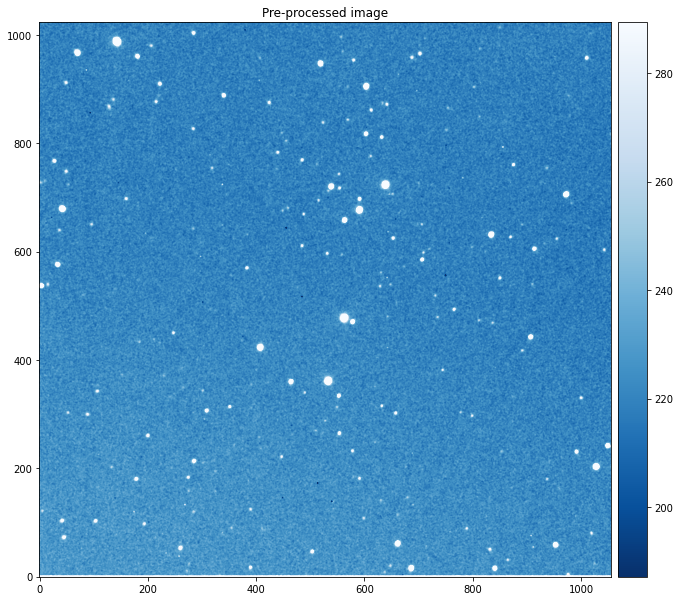

In [6]:
plots.imshow(image)
plt.title('Pre-processed image');

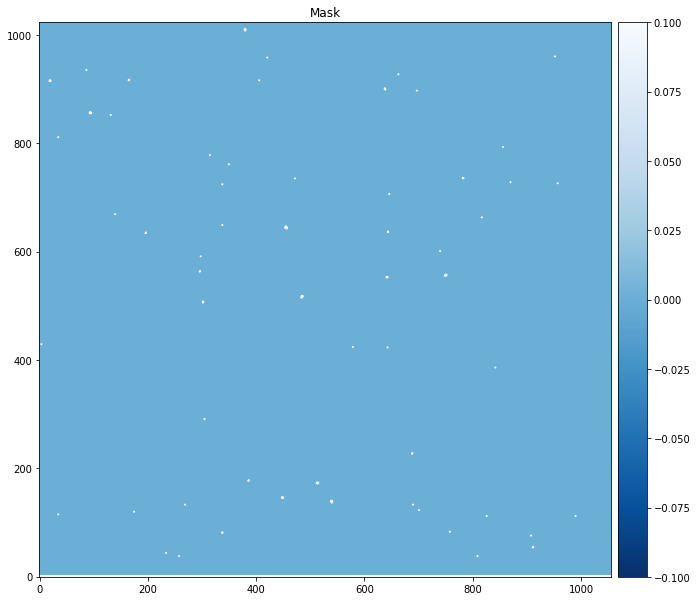

In [7]:
plots.imshow(mask)
plt.title('Mask');

# Detect and measure the objects

*STDPipe* currently contains two functions for detecting objects on the image, one based on external *SExtractor* binary, other - on Python *SEP* library. They have mostly identical signatures and arguments, but differ in minor details like meaning of returned detection flags etc.

They both return the results as a standard Astropy Table, ordered by the object brightness.

The detection in both cases is based on building the noise model through (grid-based) background and background rms estimation, and then extracting the groups of connected pixels above some pre-defined threshold. 

Optionally, the routines may automatically reject the objects detected too close to frame edge, and probably truncated or improperly measured - this is controlled by `edge` argument.

⚠️**The most important problem here is handling of blended objects, as the codes we are using cannot properly deblend close groups, except for simplest cases**⚠️

Here, we will detect objects using SExtractor and get their fluxes in apertures with 3 pixels radius

In [8]:
obj = photometry.get_objects_sextractor(
    image, 
    mask=mask, 
    aper=3.0, 
    gain=gain, 
    edge=10
)

print(len(obj), 'objects detected')

183 objects detected


The result is a table with all detected object. Let's see 3 brightest ones

In [9]:
obj[:3]

mag,magerr,flux,fluxerr,x,y,xerr,yerr,a,b,theta,FLUX_RADIUS,fwhm,flags,bg,ra,dec
mag,mag,ct,ct,pix,pix,pix2,pix2,pix,pix,deg,pix,pix,,ct,pix,pix
float32,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,int16,float32,float32,float32
-13.6994,0.0019,301841.6,532.053,563.1129,477.7723,3.7290167748e-03,4.0653935109e-03,1.879,1.705,70.45,1.719,2.98,0,220.6714,0.0000,0.0000
-13.3594,0.0023,220672.1,459.7907,533.6356,361.8192,4.3302128785e-03,4.6299340923e-03,1.892,1.695,66.46,1.785,3.16,0,222.2705,0.0000,0.0000
-13.2976,0.0023,208473.3,440.7819,639.1411,723.3804,4.6908779577e-03,4.8412779379e-03,1.921,1.736,66.42,1.819,3.14,0,219.0378,0.0000,0.0000


We may overplot these objects on the image to see whether the detection is reasonable

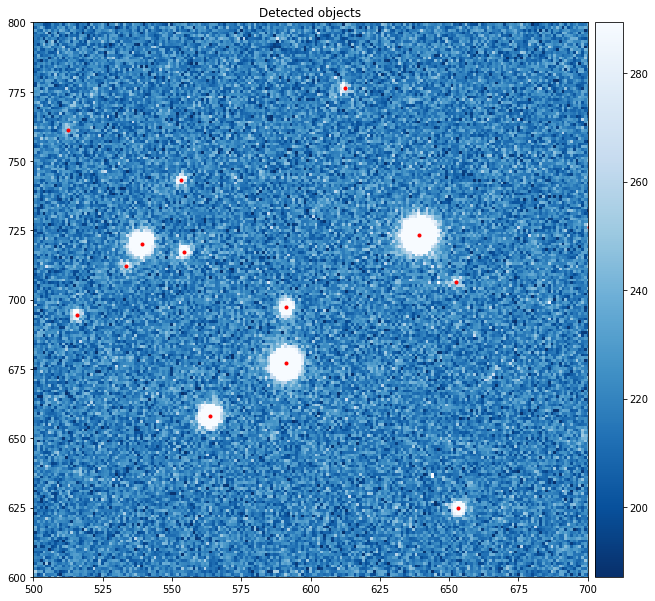

In [10]:
plots.imshow(image, interpolation='nearest')
plt.plot(obj['x'], obj['y'], 'r.')
# Zoom in to better see the details
plt.xlim(500, 700)
plt.ylim(600, 800)
plt.title('Detected objects');

Now we may measure the objects to get (a bit better) aperture photometry using the function based on [photutils](https://photutils.readthedocs.io/en/stable/) package. 

The flux is estimated as a sum of counts inside the aperture, minus sum of background values inside the same pixels. Background may be either:
 - global, estimated over a grid with size controlled throgh `bg_size` parameter in a way similar to how *SExtractor* is doing it
 - local, estimated as a mean value inside the annulus with inner and outer radii set through `bkgann` parameter, and centered on the object. 
 
The error budget of photometric measurements consists of:
 - background noise inside the aperture - this part is empirically estimated and is quite robust
 - Poissonian noise of the source itself. This component is sensitive to knowing exact gain of the detector used



⚠️**Again, for close groups of objects the measurements will be biased!**⚠️

But first, we should get a rough estimation of average FWHM of detected objects, taking into account only unflagged (e.g. not saturated) ones

In [11]:
fwhm = np.median(obj['fwhm'][obj['flags'] == 0])
print('Average FWHM is %.1f pixels' % fwhm)

Average FWHM is 4.5 pixels


We will pass this FWHM to measurement function so that aperture and background radii will be relative to it. 
We will also reject all objects with measured S/N < 5

In [12]:
obj = photometry.measure_objects(
    obj, 
    image, 
    mask=mask, 
    fwhm=fwhm, 
    gain=gain, 
    aper=1.0, # In FWHM units
    bkgann=[5, 7], # In FWHM units
    sn=5, 
    verbose=True
)

print(len(obj), 'objects properly measured')

Estimating global background with 64x64 mesh
Subtracting global background: median 219.8 rms 2.81
Using global background noise map: median 13.1 rms 0.33 + gain 1.2
Scaling aperture radii with FWHM 4.5 pix
Using aperture radius 4.5 pixels
Using local background annulus between 22.3 and 31.2 pixels
Filtering out measurements with S/N < 5.0
159 objects properly measured


# Astrometric calibration

*STDPipe* has convenience code to peform "blind" astrometric calibration using Astrometry.Net, either online service (`astrometry.blind_match_astrometrynet` function) or locally-installed one (`astrometry.blind_match_objects`). It will allow to get an initial WCS solution, if it is not already available in FITS header.

In our case, FITS header already contains WCS solution, so we will just load it.

In [13]:
# Load initial WCS
wcs = WCS(header)

# Get the center position, size and pixel scale for the image
center_ra,center_dec,center_sr = astrometry.get_frame_center(
    wcs=wcs, 
    width=image.shape[1], 
    height=image.shape[0]
)

pixscale = astrometry.get_pixscale(wcs=wcs)

print('Frame center is %.2f %.2f radius %.2f deg, %.2f arcsec/pixel' 
      % (center_ra, center_dec, center_sr, pixscale*3600))

Frame center is 154.61 -14.85 radius 0.31 deg, 1.52 arcsec/pixel


# Reference catalogue

Now we may download the catalogue for this sky region from Vizier. 

Catalogue name may be any Vizier identifier, or one of supported shortcuts for popular choices (**ps1, gaiadr2, gaiaedr3, usnob1, gsc, skymapper, apass, sdss, atlas, vsx** etc).

Column filters may be also provided to limit the output e.g. to brightest objects only. The format is the same as used on Vizier web site.

Some of catalogue shortcuts (e.g. **ps1** and **gaiadr2**) also initiate augmenting the returned catalogue with photometric data not originally stored there, most notably - Johnson-Cousins **B, V, R and I** magnitudes. The transformations used for that are either taken from literature, or derived by me by cross-matching with Landolt standard stars.

In [14]:
#Let's get PanSTARRS objects brighter than r=18 mag
cat = catalogs.get_cat_vizier(
    center_ra, 
    center_dec, 
    center_sr, 
    'ps1', 
    filters={'rmag':'<18'}
)

print(len(cat), 'catalogue stars')

506 catalogue stars


In [15]:
cat[:3]

RAJ2000,DEJ2000,objID,f_objID,Qual,e_RAJ2000,e_DEJ2000,_tab1_10,Ns,Nd,gmag,e_gmag,gKmag,e_gKmag,gFlags,rmag,e_rmag,rKmag,e_rKmag,rFlags,imag,e_imag,iKmag,e_iKmag,iFlags,zmag,e_zmag,zKmag,e_zKmag,zFlags,ymag,e_ymag,yKmag,e_yKmag,yFlags,Bmag,Vmag,Rmag,Imag,e_Bmag,e_Vmag,e_Rmag,e_Imag,B,V,R,I,good,g_SDSS,r_SDSS,i_SDSS,z_SDSS
deg,deg,,,,arcsec,arcsec,d,,,mag,mag,mag,mag,,mag,mag,mag,mag,,mag,mag,mag,mag,,mag,mag,mag,mag,,mag,mag,mag,mag,,,,,,mag,mag,mag,mag,,,,,,,,,mag
float64,float64,int64,int64,int16,float64,float64,float64,int16,int16,float64,float32,float64,float32,int32,float64,float32,float64,float32,int32,float64,float32,float64,float32,int32,float64,float32,float64,float32,int32,float64,float32,float64,float32,int32,float64,float64,float64,float64,float32,float32,float32,float32,float64,float64,float64,float64,bool,float64,float64,float64,float64
154.736155570,-15.137771850,89831547362115033,503635968,60,0.0042,0.0062,56251.627569440,5,67,17.0510,0.0035,17.1119,0.0043,115000,16.4280,0.0056,16.4824,0.0038,115000,16.1903,0.0025,16.2465,0.0030,115000,16.0951,0.0029,16.1529,0.0035,115000,16.0291,0.0044,16.0801,0.0068,115000,17.614929257533767,16.726295626545344,16.211656783084273,15.67015081559699,0.0035,0.0035,0.0056,0.0025,17.614929257533767,16.726295626545344,16.211656783084273,15.67015081559699,True,17.161709451,16.432208903,16.19603429,16.0951
154.671517130,-15.159172370,89801546715809348,503635968,60,0.0037,0.0031,56198.574571760,5,74,14.6526,0.0007,14.6955,0.0041,115000,14.0051,0.0036,14.0577,0.0014,115000,13.7456,0.0009,13.7925,0.0022,115000,13.6413,0.0012,13.6893,0.0013,115000,13.5526,0.0027,13.5464,0.0047,115000,15.224880828190853,14.314868217532652,13.782660332459214,13.214136076013533,0.0007,0.0007,0.0036,0.0009,15.224880828190853,14.314868217532652,13.782660332459214,13.214136076013533,True,14.76745336875,14.009624793750001,13.751915062499998,13.6413
154.643863010,-15.143614170,89821546439378014,503635968,60,0.0026,0.0025,56197.320011570,5,79,16.7401,0.0052,16.7998,0.0031,115000,15.7642,0.0015,15.8180,0.0021,115000,15.3591,0.0024,15.4108,0.0024,115000,15.1842,0.0030,15.2330,0.0035,115000,15.0612,0.0030,15.1002,0.0039,115000,17.47170528132223,16.235118747580938,15.5027855629425,14.73753754518563,0.0052,0.0052,0.0015,0.0024,17.47170528132223,16.235118747580938,15.5027855629425,14.73753754518563,True,16.912700735390004,15.77377026567,15.374358708099999,15.1842


# Astrometric refinement

Now we may refine the astrometric solution based on the positions of detected objects and catalogue stars. *STDPipe* supports both calling *SCAMP* external binary (`astrometry.refine_wcs_scamp`, it will provide WCS solution based on PV distortions) or using simple positional list matching and *AstroPy*-based WCS fitting (`astrometry.refine_wcs`, SIP distortions). The difference in exact distortion representation is not important inside Python, but may become problematic if you save the WCS back to FITS header and try to use it with some software what do not handle it (e.g. *SWarp* and *SExtractor* do not know SIP).

Both methods are accessible uniformly through higher-level `pipeline.refine_astrometry` function. If the refinement fails, it will return `None` - do not forget to check for it!

In [16]:
# Use SCAMP for astrometric refinement.
wcs = pipeline.refine_astrometry(
    obj, 
    cat, 
    5*pixscale, 
    wcs=wcs, 
    method='scamp', 
    cat_col_mag='rmag', 
    verbose=True
)

if wcs is not None:
    # Remove astrometric keywords from existing header
    astrometry.clear_wcs(
        header, 
        remove_comments=True, 
        remove_underscored=True, 
        remove_history=True
    )
    
    # Update WCS info in the header
    header.update(wcs.to_header(relax=True))
else:
    print("Astrometric refinement failed")

Astrometric refinement using 7.6 arcsec radius, photometric matching and scamp WCS fitting
Using 159 objects and 506 catalogue stars
Using user-provided local catalogue
Will run SCAMP like that:
/Users/karpov/opt/miniconda3/envs/stdpipe/bin/scamp /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/scampsyhzjd09/objects.cat -c /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/scampsyhzjd09/empty.conf -VERBOSE_TYPE QUIET -SOLVE_PHOTOM N -CHECKPLOT_TYPE NONE -WRITE_XML Y -XML_NAME /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/scampsyhzjd09/scamp.xml -PROJECTION_TYPE TPV -CROSSID_RADIUS 7.609978569318471 -DISTORT_DEGREES 1 -HEADER_NAME /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/scampsyhzjd09/objects.head -ASTREF_CATALOG FILE -ASTREFCAT_NAME /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/scampsyhzjd09/catalogue.cat
SCAMP run successfully
102 matches, chi2 6.2
Got WCS solution with CTYPE1 = RA---TPV  and without PV keywords, fixing it
Astrometric accuracy: 0.00" 0.00"


# Photometric calibration

Photometric calibration is performed by positionally matching detected objects with catalogue stars, and then building the photometric model for their instrumental magnitudes.

The model includes:
 - catalogue magnitude
 - (optionally spatially varying) zero point
 - (optionally) catalogue color
 - (very optionally) additive flux term, corresponding e.g. to biased background estimation
 - (very very optionally) intrinsic scatter on top of measurement errors
 
and looks like that:
$$ 
\mbox{Catalogue} = \mbox{Instrumental} + C\cdot\mbox{color} + \mbox{polynomial}(x, y, degree) + \mbox{err}
$$

where $\mbox{Catalogue}$ is e.g. $\mbox{V}$ magnitude and $\mbox{color}$ is e.g $\mbox{B-V}$

This is equivalent to the instrumenmtal photometric system defined as $\mbox{V} - C\cdot(\mbox{B-V})$.

The low-level calibration is implemented in `photometry.match` function, and wrapped into a bit higher-level and easier to use `pipeline.calibrate_photometry`. The routines perform an iterative fitting with rejection of pairs deviating too much (more than `threshold` sigmas) from the model. Optional intrinsic scatter (specified through `max_intrinsic_rms` parameter) may help accounting for the effects of e.g. multiplicative noise (flatfielding, subpixel sensitivity variations, etc). 

⚠️**The calibration (or zero point, or systematic) error is currently estimated as a fitted model error, and is typically way too small. It is probably underestimating the actual error!**⚠️

In [17]:
# Photometric calibration using 2 arcsec matching radius, 
# r magnitude, g-r color and second order spatial variations
m = pipeline.calibrate_photometry(
    obj, 
    cat, 
    # Matching radius, in degrees
    sr=2/3600, 
    # Primary filter column name
    cat_col_mag='rmag',
    # Color term
    cat_col_mag1='gmag', 
    cat_col_mag2='rmag', 
    # Allow some scatter on top of formal error bars
    max_intrinsic_rms=0.02, 
    # Spatial order of the model
    order=2, 
    verbose=True
)

# The code above automatically augments the object list 
# with calibrated magnitudes, but we may also do it manually
obj['mag_calib'] = obj['mag'] + m['zero_fn'](
    obj['x'], 
    obj['y']
)

obj['mag_calib_err'] = np.hypot(
    obj['magerr'], m['zero_fn'](
        obj['x'], 
        obj['y'], 
        get_err=True
    )
)

Performing photometric calibration of 159 objects vs 506 catalogue stars
Using 2.0 arcsec matching radius, rmag magnitude and spatial order 2
Using (gmag - rmag) color for color term
164 initial matches between 159 objects and 506 catalogue stars, sr = 2.00 arcsec
Median separation is 0.28 arcsec
Fitting the model with spatial_order = 2
Using robust fitting
Using color term
155 objects pass initial quality cuts
Iteration 0 : 155 / 164 - rms 0.22 0.22 - normed 43.04 8.69 - scale 1.31 1.00 - rms 0.02
Iteration 1 : 145 / 164 - rms 0.23 0.14 - normed 5.54 1.55 - scale 1.02 1.00 - rms 0.02
Iteration 2 : 143 / 164 - rms 0.23 0.14 - normed 4.54 1.36 - scale 1.01 1.00 - rms 0.02
Fitting converged
143 good matches
Intrinsic scatter is 0.02
Color term is -0.09
Photometric calibration finished successfully.


### Plotting the calibration results

There is a handy plotting function useful for quick checking of fitting quality and uncorrected trends. It marks the stars used for final model fit with red dots, and flagged (e.g. saturated) stars rejected from the fitting from the start - with yellow diagonal crosses. The rest of points are the ones that got rejected during the iterative model fitting process

(0.0, 1.5)

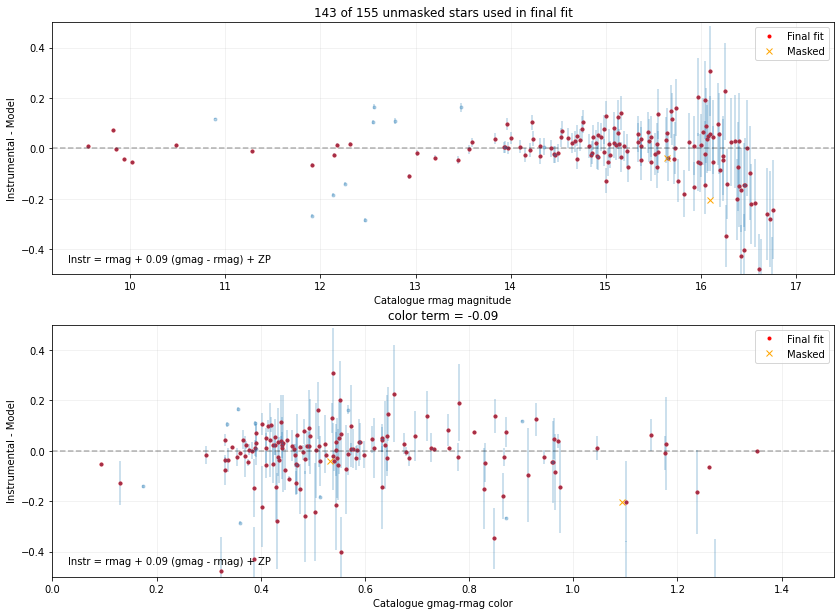

In [18]:
# Photometric residuals as a function of catalogue magnitude
plt.subplot(211)
plots.plot_photometric_match(m)
plt.ylim(-0.5, 0.5)

# Photometric residuals as a function of catalogue color
plt.subplot(212)
plots.plot_photometric_match(m, mode='color')
plt.ylim(-0.5, 0.5)
plt.xlim(0.0, 1.5)

Text(0.5, 1.0, 'Zero point model')

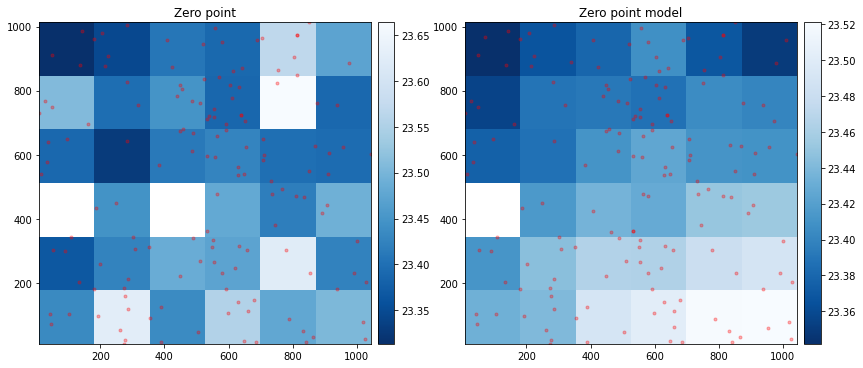

In [19]:
# Zero point (difference between catalogue and instrumental magnitudes for every star) map
plt.subplot(121)
plots.plot_photometric_match(
    m, 
    mode='zero', 
    bins=6, 
    # Whether to show positions of the stars
    show_dots=True, 
    color='red', 
    aspect='equal'
)

plt.title('Zero point')

# Fitted zero point model with second-order spatial polynomial term
plt.subplot(122)
plots.plot_photometric_match(
    m, 
    mode='model', 
    bins=6, 
    show_dots=True, 
    color='red', 
    aspect='equal'
)

plt.title('Zero point model')



## Simple catalogue-based transient detection

Anyway, at this point we already have the detections of all sufficiently isolated and sufficiently bright objects on the frame, and photometric calibration for them. 

Some transients may already be detected by comparing the detected objects with catalogue, and selecting the ones that do not have any counterpart there. This approach is limited, as
 - it does not play well with blended objects, as they are often being detected as a single extended thing with centroid separated from the centres of individual components
 - it does not easily allow to detect flares or low-amplitude variability of objects that are present in the catalogue
 
Anyway, let's do it. We have a dedicated routine `pipeline.filter_transient_candidates` that accepts the list of objects, and filters out the following things:
 - flagged ones, i.e. with `obj['flags'] != 0`
 - positionally coincident with stars from provided cataloge table (if `cat != None`)
 - positionally coincident with stars from Vizier catalogues specified as a list of names (if `vizier` list is non-empty)
 - positionally and temporally coincident with Solar system objects from SkyBoT service (if `skybot = True` and `time` is provided, or is present in the object list as a column)
 - positionally coincident with NED objects (if `ned = True`)

As we are already using PanSTARRS as a reference catalogue, let's limit Vizier filtering to variable stars only. And as an input list of candidates, let's just use all detected objects.

In [20]:
# Filtering of transient candidates
candidates = pipeline.filter_transient_candidates(
    obj,
    cat=cat, 
    sr=2/3600,
    # We will check only against AAVSO VSX
    vizier=['vsx'], 
    verbose=True
)

Candidate filtering routine started with 159 initial candidates and 2.0 arcsec matching radius
159 of them are unflagged
4 of them are not matched with reference catalogue
4 remains after matching with AAVSO VSX
4 candidates remaining after filtering


Now we may create cutouts for these surviving candidates and vizualize them, also downloading corresponding cutouts from PanSTARRS itself

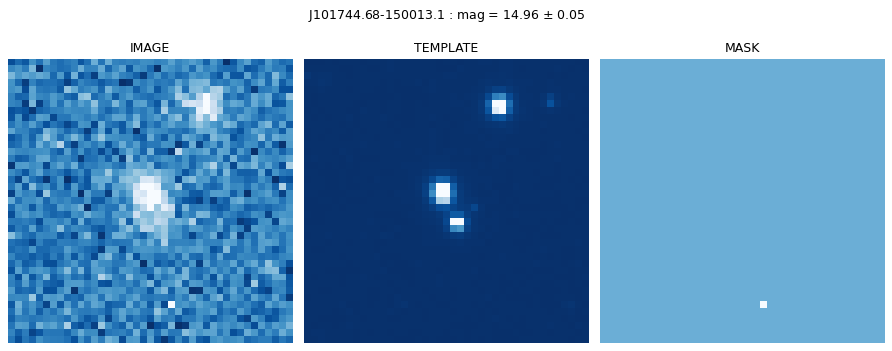

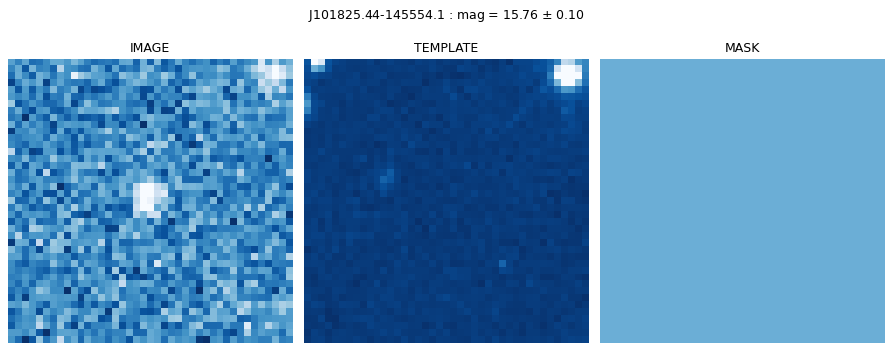

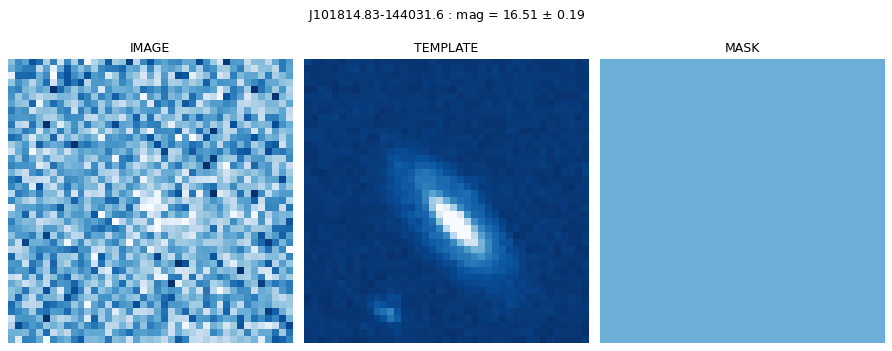

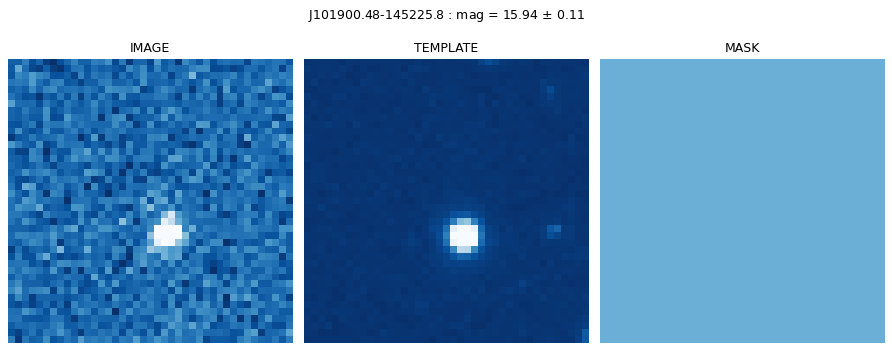

In [21]:
for i,cand in enumerate(candidates):
    # Create the cutout from image based on the candidate
    cutout = cutouts.get_cutout(
        # Image
        image, 
        # Candidate
        cand, 
        # Cutout half-size in pixels
        20,
        # Additional planes for the cutout
        mask=mask, 
        # FITS header to include with the cutout - with automatically adjusted WCS solution
        header=header
    )
    
    # We did not do image subtraction yet, but we may already
    # directly download the "template" image for this cutout 
    # from HiPS server - same scale and orientation, but different PSF shape!..
    cutout['template'] = templates.get_hips_image(
        # HiPS survey name - anything from http://aladin.cds.unistra.fr/hips/list goes!
        'PanSTARRS/DR1/r',
        # FITS header with proper WCS and size
        header=cutout['header'],
        # Return only image
        get_header=False 
    )
    
    # Now we have three image planes in the cutout - let's display them
    plots.plot_cutout(
        cutout, 
        # Image planes to display - optional, by default displays everything
        planes=['image', 'template', 'mask'],
        # Percentile-based scaling and linear stretching
        qq=[0.5, 99.5], 
        stretch='linear')
    plt.show()

Second one is definitely the transient we are looking for, but the first, brighter one is an unresolved blend. It may be additionally filtered out based on PSF fitting $\chi^2$, or `spread_model` field, or large photometric error, or morphological characteristics.

# Image subtraction

More accurate and stable transient detection is performed using *image subtraction*. 

Image subtraction in *STDPipe* is performed using [HOTPANTS](https://github.com/acbecker/hotpants) code (or ZOGY algorithm optionally), and needs the following:
 - template image, astrometrically aligned with science image
 - masks for both template and science images
 - noise models for the template and science images

## Templates - Pan-STARRS or Legacy Survey

The template may be some image or coadd from the same instrument or some other archive - e.g. *STDPipe* supports downloading images from Pan-STARRS or DESI Legacy Survey. The template should be astrometrically aligned with science image, and probably mosaicked too. For Pan-STARRS or DESI Legacy Survey, we have convenient wrapper `templates.get_survey_image` for doing that, while for other surveys one will need to handle it using external Python libraries like [AstroAlign](https://github.com/quatrope/astroalign) or [MontagePy](http://montage.ipac.caltech.edu/docs/montagePy-UG.html). It will be covered in additional tutorial.

In [22]:
# Get r band image from Pan-STARRS with the same resolution and orientation
tmpl = templates.get_survey_image(
    band='r',
    # One of 'image' or 'mask'
    ext='image',
    # Either 'ps1' for Pan-STARRS or 'ls' for Legacy Survey
    survey='ps1',
    # pixel grid defined by WCS and image size
    wcs=wcs,
    width=image.shape[1],
    height=image.shape[0],
    verbose=True
)

# Also get proper mask
tmask = templates.get_survey_image(
    band='r',
    # One of 'image' or 'mask'
    ext='mask',
    # Either 'ps1' for Pan-STARRS or 'ls' for Legacy Survey
    survey='ps1',
    # pixel grid defined by WCS and image size
    wcs=wcs,
    width=image.shape[1],
    height=image.shape[0],
    verbose=True
)
# Mask bits for Pan-STARRS are documented at https://outerspace.stsci.edu/display/PANSTARRS/PS1+Pixel+flags+in+Image+Table+Data
# We will exclude pixels with any non-zero mask value
tmask = tmask > 0
# We will also mask the regions of the template filled with NaNs
tmask |= np.isnan(tmpl)

Cache location not specified, falling back to /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/ps1
rings.v3.skycell.1004.016.stk.r.unconv.fits already downloaded
rings.v3.skycell.1004.017.stk.r.unconv.fits already downloaded
rings.v3.skycell.1004.026.stk.r.unconv.fits already downloaded
rings.v3.skycell.1004.027.stk.r.unconv.fits already downloaded
rings.v3.skycell.1004.028.stk.r.unconv.fits already downloaded
rings.v3.skycell.1004.036.stk.r.unconv.fits already downloaded
rings.v3.skycell.1004.037.stk.r.unconv.fits already downloaded
Will run SWarp like that:
/Users/karpov/opt/miniconda3/envs/stdpipe/bin/swarp -VERBOSE_TYPE NORMAL -IMAGEOUT_NAME /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/swarpinu37oav/coadd.fits -WEIGHTOUT_NAME /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/swarpinu37oav/coadd.weights.fits -c /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/swarpinu37oav/empty.conf -XML_NAME /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/swarpinu37oav/swarp.xml -VMEM_DIR /var

> 
----- SWarp 2.38.0 started on 2023-08-25 at 05:14:02 with 4 threads

> Examining input data ...
> Looking for rings.v3.skycell.1004.016.stk.r.unconv.fits ...
> Looking for rings.v3.skycell.1004.017.stk.r.unconv.fits ...
> Looking for rings.v3.skycell.1004.026.stk.r.unconv.fits ...
> Looking for rings.v3.skycell.1004.027.stk.r.unconv.fits ...
> Looking for rings.v3.skycell.1004.028.stk.r.unconv.fits ...
> Looking for rings.v3.skycell.1004.036.stk.r.unconv.fits ...
> Looking for rings.v3.skycell.1004.037.stk.r.unconv.fits ...
> Creating NEW output image ...

> WARNING: FITS header data read in /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/swarpinu37oav/coadd.head

> Creating NEW weight-map ...
> 
------- Output File coadd.fits:
    "no ident"  WEIGHTED  EXT. HEADER  1056x1024  32 bits (floats)
    Center: 10:18:26.79 -14:51:15.4   26.8'x26'  Scale: 1.524 ''/pixel
    Gain: 0 e-/ADU   Flux scaling (astrom/photom): 1 X / 1 X

> Loading input data ...
> 
-------------- File rings.v3.s

> Resampling /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/ps1/rings.v3.skycell.1004.017.stk.r.unconv.fits ...
> Resampling line:      0 / 1      
> 
-------------- File rings.v3.skycell.1004.026.stk.r.unconv.fits:
    "no ident"  unweighted  no ext. header  6242x6254  32 bits (floats)
    Center: 10:19:19.99 -15:00:05.1   26'x26.1'  Scale: 0.2499 ''/pixel
    Gain: 0 e-/ADU   Flux scaling (astrom/photom): 37.17 X / 1 X
> Setting up background maps ...
> Setting up background map at line:    128 / 6254   
> Setting up background map at line:    256 / 6254   
> Setting up background map at line:    384 / 6254   
> Setting up background map at line:    512 / 6254   
> Setting up background map at line:    640 / 6254   
> Setting up background map at line:    768 / 6254   
> Setting up background map at line:    896 / 6254   
> Setting up background map at line:   1024 / 6254   
> Setting up background map at line:   1152 / 6254   
> Setting up background map at line:   1280 / 6254   


> Setting up background map at line:   3840 / 6254   
> Setting up background map at line:   3968 / 6254   
> Setting up background map at line:   4096 / 6254   
> Setting up background map at line:   4224 / 6254   
> Setting up background map at line:   4352 / 6254   
> Setting up background map at line:   4480 / 6254   
> Setting up background map at line:   4608 / 6254   
> Setting up background map at line:   4736 / 6254   
> Setting up background map at line:   4864 / 6254   
> Setting up background map at line:   4992 / 6254   
> Setting up background map at line:   5120 / 6254   
> Setting up background map at line:   5248 / 6254   
> Setting up background map at line:   5376 / 6254   
> Setting up background map at line:   5504 / 6254   
> Setting up background map at line:   5632 / 6254   
> Setting up background map at line:   5760 / 6254   
> Setting up background map at line:   5888 / 6254   
> Setting up background map at line:   6016 / 6254   
> Setting up background map 

> Resampling /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/ps1/rings.v3.skycell.1004.028.stk.r.unconv.fits ...
> Resampling line:      0 / 680    
> 
-------------- File rings.v3.skycell.1004.036.stk.r.unconv.fits:
    "no ident"  unweighted  no ext. header  6242x6254  32 bits (floats)
    Center: 10:19:20.25 -14:36:02.0   26'x26.1'  Scale: 0.25 ''/pixel
    Gain: 0 e-/ADU   Flux scaling (astrom/photom): 37.16 X / 1 X
> Setting up background maps ...
> Setting up background map at line:    128 / 6254   
> Setting up background map at line:    256 / 6254   
> Setting up background map at line:    384 / 6254   
> Setting up background map at line:    512 / 6254   
> Setting up background map at line:    640 / 6254   
> Setting up background map at line:    768 / 6254   
> Setting up background map at line:    896 / 6254   
> Setting up background map at line:   1024 / 6254   
> Setting up background map at line:   1152 / 6254   
> Setting up background map at line:   1280 / 6254   
> 

> Resampling /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/ps1/rings.v3.skycell.1004.037.stk.r.unconv.fits ...
> Resampling line:      0 / 426    
> Resampling line:      9 / 426    
> Resampling line:     18 / 426    
> Resampling line:     27 / 426    
> Resampling line:     36 / 426    
> Resampling line:     45 / 426    
> Resampling line:     54 / 426    
> Resampling line:     63 / 426    
> Resampling line:     72 / 426    
> Resampling line:     81 / 426    
> Resampling line:     90 / 426    
> Resampling line:     99 / 426    
> Resampling line:    108 / 426    
> Resampling line:    117 / 426    
> Resampling line:    126 / 426    
> Resampling line:    135 / 426    
> Resampling line:    144 / 426    
> Resampling line:    153 / 426    
> Resampling line:    162 / 426    
> Resampling line:    171 / 426    
> Resampling line:    180 / 426    
> Resampling line:    189 / 426    
> Resampling line:    198 / 426    
> Resampling line:    207 / 426    
> Resampling line:    

SWarp run successfully in 8.24 seconds
Cache location not specified, falling back to /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/ps1
rings.v3.skycell.1004.016.stk.r.unconv.mask.fits already downloaded
rings.v3.skycell.1004.017.stk.r.unconv.mask.fits already downloaded
rings.v3.skycell.1004.026.stk.r.unconv.mask.fits already downloaded
rings.v3.skycell.1004.027.stk.r.unconv.mask.fits already downloaded
rings.v3.skycell.1004.028.stk.r.unconv.mask.fits already downloaded
rings.v3.skycell.1004.036.stk.r.unconv.mask.fits already downloaded
rings.v3.skycell.1004.037.stk.r.unconv.mask.fits already downloaded
The images will be handled as integer flags
Will run SWarp like that:
/Users/karpov/opt/miniconda3/envs/stdpipe/bin/swarp -VERBOSE_TYPE NORMAL -IMAGEOUT_NAME /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/swarpifm0invm/coadd.fits -WEIGHTOUT_NAME /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/swarpifm0invm/coadd.weights.fits -c /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/swar

> Resampling /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/ps1/rings.v3.skycell.1004.016.stk.r.unconv.mask.fits ...
> Resampling line:      0 / 1      
> 
-------------- File rings.v3.skycell.1004.017.stk.r.unconv.mask.fits:
    "no ident"  unweighted  no ext. header  6242x6254  16 bits (integers)
    Center: 10:17:40.16 -15:24:02.3   26'x26'  Scale: 0.2498 ''/pixel
    Gain: 0 e-/ADU   Flux scaling (astrom/photom): 37.19 X / 1 X
    Background: 0   RMS: 0

> Reading /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/ps1/rings.v3.skycell.1004.017.stk.r.unconv.mask.fits
> Resampling /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/ps1/rings.v3.skycell.1004.017.stk.r.unconv.mask.fits ...
> Resampling line:      0 / 1      
> 
-------------- File rings.v3.skycell.1004.026.stk.r.unconv.mask.fits:
    "no ident"  unweighted  no ext. header  6242x6254  16 bits (integers)
    Center: 10:19:19.99 -15:00:05.1   26'x26.1'  Scale: 0.2499 ''/pixel
    Gain: 0 e-/ADU   Flux scaling (astrom/photom)

> 
-------------- File rings.v3.skycell.1004.028.stk.r.unconv.mask.fits:
    "no ident"  unweighted  no ext. header  6242x6254  16 bits (integers)
    Center: 10:16:01.24 -14:59:51.6   26'x26'  Scale: 0.2498 ''/pixel
    Gain: 0 e-/ADU   Flux scaling (astrom/photom): 37.19 X / 1 X
    Background: 0   RMS: 0

> Reading /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/ps1/rings.v3.skycell.1004.028.stk.r.unconv.mask.fits
> Resampling /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/ps1/rings.v3.skycell.1004.028.stk.r.unconv.mask.fits ...
> Resampling line:      0 / 680    
> 
-------------- File rings.v3.skycell.1004.036.stk.r.unconv.mask.fits:
    "no ident"  unweighted  no ext. header  6242x6254  16 bits (integers)
    Center: 10:19:20.25 -14:36:02.0   26'x26.1'  Scale: 0.25 ''/pixel
    Gain: 0 e-/ADU   Flux scaling (astrom/photom): 37.16 X / 1 X
    Background: 0   RMS: 0

> Reading /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/ps1/rings.v3.skycell.1004.036.stk.r.unconv.mask.fits
>

SWarp run successfully in 1.78 seconds


> Co-adding line:      1 / 1024   
> Writing   line:      1 / 1024   
> Closing files ...
> 
> All done (in 1.8 s)


Text(0.5, 1.0, 'Template mask')

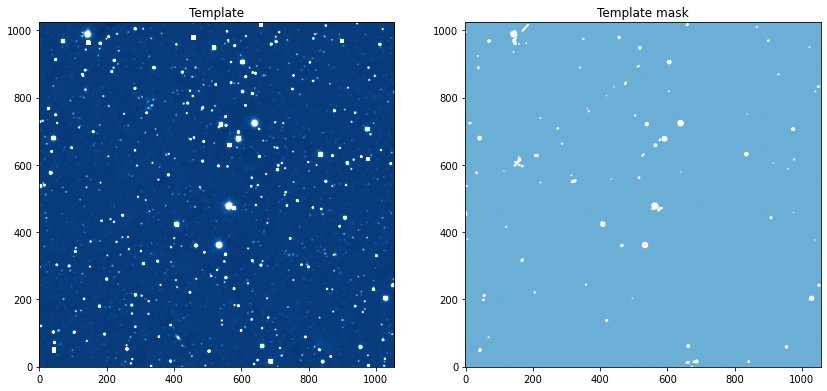

In [23]:
plt.subplot(121)
plots.imshow(tmpl, show_colorbar=False)
plt.title('Template')

plt.subplot(122)
plots.imshow(tmask, show_colorbar=False)
plt.title('Template mask')


# Subtracting the images with HOTPANTS

Image subtraction is implemented in `subtraction.run_hotpants` routine, that implements the following logic on top of running `hotpants` binary:
 - finding optimal convolutuon kernel sizes based on image and template FWHM
 - filling in necessary parameters like min/max pixel values, etc
     - also, all parameters may be overwritten or added by passing them through `extra` argument, allowing full control over the code
 - (optionally) building noise models for the image and template based on their background statistics and gain, so that they may be e.g. background-subtracted
     - noise model is again based on background rms + Poisson contribution from the object flux
 - (optionally) constructing the list of stamp positions used for fitting the convolution kernel based on user-supplied list of coordinates (e.g. detected objects)

The routine optionally returns, along with difference image, the template convolved with the kernel (so supposedly matching the science image resolution), noise-scaled difference image, and the error model. The latters may be used to assess the significance of detections.

In [24]:
import photutils

# Prepare the subtraction by estimating image and template backgrounds
bg = photutils.Background2D(
    image, 
    128, # Grid size in pixels
    mask=mask, 
    exclude_percentile=30
).background

template_bg = photutils.Background2D(
    tmpl, 
    128, # Grid size in pixels
    mask=tmask, 
    exclude_percentile=30
).background

# Run the subtraction and get all possible result planes
diff,conv,sdiff,ediff = subtraction.run_hotpants(
    # Background-subtracted image
    image-bg, 
    # Background-subtracted template
    tmpl-template_bg, 
    # Masks
    mask=mask, 
    template_mask=tmask,
    # FWHMs for the convolution kernel size
    image_fwhm=fwhm, 
    template_fwhm=1.5, 
    # Parameters for the noise model
    image_gain=gain, 
    template_gain=1e6, 
    # Estimate noise model for the image automatically
    err=True, 
    template_err=True,
    # Output parameters
    get_convolved=True, 
    get_scaled=True, 
    get_noise=True, 
    verbose=True
)

# Bad pixels as marked by HOTPANTS
dmask = diff == 1e-30 

Building noise model from the image
Building noise model from the template
Will run HOTPANTS like that:
/opt/local/bin/hotpants -inim /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/hotpantsvbcz7ndy/image.fits -tmplim /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/hotpantsvbcz7ndy/template.fits -outim /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/hotpantsvbcz7ndy/diff.fits -savexy /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/hotpantsvbcz7ndy/stamps.reg -imi /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/hotpantsvbcz7ndy/imask.fits -tmi /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/hotpantsvbcz7ndy/tmask.fits -il -133.63980483133057 -iu 32071.86946308688 -tl -8.735153148140178 -tu 16134.714338716123 -tuk 16134.714338716123 -n i -allm -c t -hki -nrx 1 -nry 1 -ko 0 -bgo 0 -v 2 -ini /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/hotpantsvbcz7ndy/err.fits -tni /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/hotpantsvbcz7ndy/terr.fits -ng 3 6 0.8941467442466076 4 1.78829348

Doing : /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/hotpantsvbcz7ndy/image.fits -
        /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/hotpantsvbcz7ndy/template.fits =
        /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/hotpantsvbcz7ndy/diff.fits
   Good templ data : -8.7 -> 16134.7
   Good image data : -133.6 -> 32071.9
Mallocing massive amounts of memory...
Region 0 pixels            : 1:1056,1:1024
 Vector Indices (buffered) : 0:1055,0:1023
 Vector Indices (good data): 0:1055,0:1023
Allocating stamps...
Build stamp  : t    0 i    0 (grid coord  0  0)
    Stamp in region : 0:72,0:72
    Tmpl  xs :   36 ys :   36  (sky,dsky = -0.0,1.1)
    ...only found 0 good substamps by autosearch
    NO good pixels, skipping...
    Tmpl     : scnt =  0 nss =  0
    templ: 0 substamps
Build stamp  : t    0 i    0 (grid coord  1  0)
    Stamp in region : 105:177,0:72
    Tmpl  xs :  141 ys :   36  (sky,dsky = 0.5,0.9)
    ...only found 0 good substamps by autosearch
    NO good pixels,

    xss :  543 yss :   64
    xs  :   36 ys  :  138 sig:  0.000 sscnt:    0 nss:    1 
    xss :   55 yss :  172
    xs  :  141 ys  :  138 sig:  0.000 sscnt:    0 nss:    2 
    xss :  109 yss :  165
    xs  :  247 ys  :  138 sig:  0.000 sscnt:    0 nss:    2 
    xss :  238 yss :  171
    xs  :  352 ys  :  138 sig:  0.000 sscnt:    0 nss:    2 
    xss :  324 yss :  158
    xs  :  458 ys  :  138 sig:  0.000 sscnt:    0 nss:    1 
    xss :  462 yss :  111
    xs  :  564 ys  :  138 sig:  0.000 sscnt:    0 nss:    2 
    xss :  599 yss :  108
    xs  :  669 ys  :  138 sig:  0.000 sscnt:    0 nss:    2 
    xss :  661 yss :  115
    xs  :  775 ys  :  138 sig:  0.000 sscnt:    0 nss:    2 
    xss :  796 yss :  162
    xs  :  880 ys  :  138 sig:  0.000 sscnt:    0 nss:    3 
    xss :  872 yss :  164
    xs  :  986 ys  :  138 sig:  0.000 sscnt:    0 nss:    2 
    xss : 1016 yss :  126
    xs  :   36 ys  :  240 sig:  0.000 sscnt:    0 nss:    1 
    xss :   61 yss :  274
    xs  :  141 ys

    xss :  804 yss :  118


    # 16    xss:  447 yss:  221 sig:  0.993 sscnt:  0 nss:  2 ITERATE substamp (poor sig)
    xs  :  458 ys  :  240 sig:  0.993 sscnt:    1 nss:    2 
    xss :  466 yss :  261

    84 out of 88 stamps remain

 Re-Expanding Matrix
 Mat_size: 50 ncomp2: 1 ncomp1: 48 nbg_vec: 1 
 Checking again
    # 0    xss:  424 yss:   63 sig:  0.988 sscnt:  0 nss:  2 OK
    # 1    xss:  543 yss:   64 sig:  0.899 sscnt:  0 nss:  2 OK
    # 2    xss:   55 yss:  172 sig:  0.912 sscnt:  0 nss:  1 OK
    # 3    xss:  109 yss:  165 sig:  0.885 sscnt:  0 nss:  2 OK
    # 4    xss:  238 yss:  171 sig:  0.909 sscnt:  0 nss:  2 OK
    # 5    xss:  324 yss:  158 sig:  0.905 sscnt:  0 nss:  2 OK
    # 6    xss:  462 yss:  111 sig:  0.919 sscnt:  0 nss:  1 OK
    # 7    xss:  599 yss:  108 sig:  0.922 sscnt:  0 nss:  2 OK
    # 8    xss:  661 yss:  115 sig:  0.949 sscnt:  0 nss:  2 OK
    # 9    xss:  804 yss:  118 sig:  0.869 sscnt:  1 nss:  2 OK
    # 10    xss:  872 yss:  164 sig:  

 Sum Kernel at 0,0: 0.239405
 Sum Kernel at 1055,1023: 0.239405
 Using Kernel Sum = 0.239405

 Creating and writing output images...
   FINAL Mean sig:  0.922 stdev:  0.030
 Getting diffim stats for GOOD pixels : 
   Mean   : 0.06
   Median : -0.06
   Mode   : -0.82
   Stdev  : 13.08
   FWHM   : 13.21
   lFWHM  : 13.11
 Getting noiseim stats for GOOD pixels : 
   Mean   : 13.47
   Median : 13.42
   Mode   : 13.20
   Stdev  : 0.41
   FWHM   : 0.44
   lFWHM  : 0.40
 Emperical / Expected Noise for GOOD pixels = 0.97
 X2NORM = 0.93

 Getting diffim stats for OK pixels : 
   Mean   : 0.73
   Median : 0.53
   Mode   : 0.55
   Stdev  : 13.32
   FWHM   : 13.35
   lFWHM  : 13.23
 Getting noiseim stats for OK pixels : 
   Mean   : 13.45
   Median : 13.39
   Mode   : 13.13
   Stdev  : 0.43
   FWHM   : 0.46
   lFWHM  : 0.40
 Emperical / Expected Noise for OK pixels = 0.99

Region 0 finished

SUCCESS


HOTPANTS run succeeded
83 stamps used


Text(0.5, 1.0, 'Noise-scaled difference image')

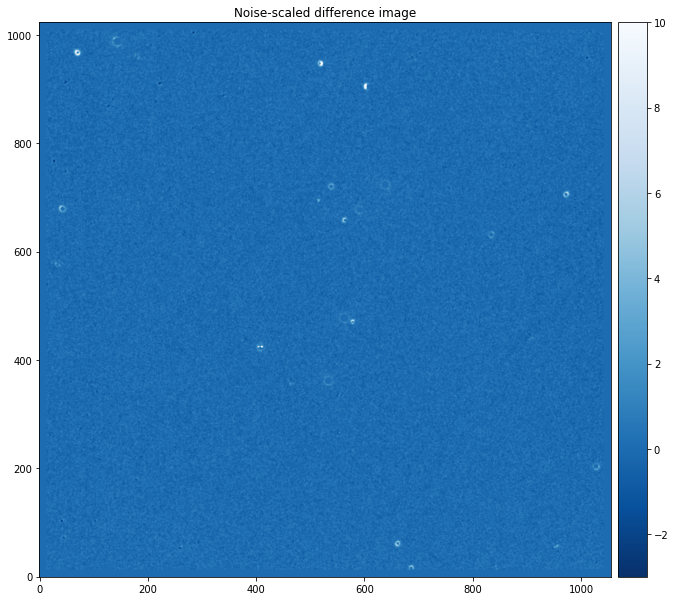

In [25]:
# Set to zero all masked pixels
sdiff[mask|tmask|dmask] = 0

plots.imshow(sdiff, vmin=-3, vmax=10)
plt.title('Noise-scaled difference image')

Not every star got fully subtracted - these are mostly saturated objects that are masked. They will be rejected on the next step.

# Transient detection on difference image

Transient detection on difference image differs from the one we did on original image in two ways:
 - there are much less remaining sources
 - most of them are subtraction artefacts that have different PSF shape, so may be filtered out
 - we know the noise model for the difference image
 
Knowing noise model also helps filtering out subtraction artefacts as they mostly happen in high-noise regions (inside stellar footprints).

So we will use the noise model, and will perform PSF photometry. We will also show how to pass extra parameters to *SExtractor* to get extra fields in the output, inspect checkimages, etc. We will also use PSF model built by *PSFEx* (see appendix) for getting some parameters based on model fitting.

⚠️**The code for running SExtractor here needs full path to `default.nnw` file on your system - you have to find it using e.g. `locate default.nnw` and modify the path accordingly, or it will fail!**

In [26]:
# Get PSF model and store it to temporary file
psf_model = psf.run_psfex(
    image, 
    mask=mask, 
    # No spatial variance for PSF model
    order=0, 
    gain=gain, 
    # Store PSF model to this file
    psffile='/tmp/psf.psf', 
    verbose=True
)

# Run SExtractor on difference image with custom noise model, 
# returning object footprints and some additional fields
sobj,segm = photometry.get_objects_sextractor(
    # Operate on difference image
    diff, 
    # Combined mask
    mask=mask | tmask | dmask, 
    # Error model
    err=ediff,
    # Exclude everything closer than 20 pixels to the edge
    edge=20,
    wcs=wcs, 
    aper=5.0,
    # Get extra object parameters
    extra_params=['CLASS_STAR', 'NUMBER'], 
    # Pass extra configuration parameters to SExtractor
    extra={
        'SEEING_FWHM':fwhm,
        'STARNNW_NAME':'/Users/karpov/opt/miniconda3/envs/stdpipe/share/sextractor/default.nnw'
    }, 
    # Also return the segmentation map
    checkimages=['SEGMENTATION'], 
    # Use PSF model we just built 
    psf='/tmp/psf.psf', 
    verbose=True)

# Perform forced aperture photometry, again with custom noise model and forced zero background level
sobj = photometry.measure_objects(
    sobj, 
    # Operate on difference image
    diff, 
    # Combined mask
    mask=mask | tmask | dmask, 
    # Known noise model for difference image
    err=ediff,
    # Here we use the same parameters as for forced photometry on original image
    fwhm=fwhm, 
    aper=1.0, 
    bkgann=[5, 7], 
    # Filter out everything with S/N < 3
    sn=3, 
    verbose=True
)

# The difference is in original image normalization, so we know photometric zero point
sobj['mag_calib'] = sobj['mag'] + m['zero_fn'](
    sobj['x'], 
    sobj['y']
)
sobj['mag_calib_err'] = np.hypot(
    sobj['magerr'], m['zero_fn'](
        sobj['x'], 
        sobj['y'], 
        get_err=True
    )
)

# We may immediately reject flagged objects as they correspond to imaging artefacts (masked regions)
sobj = sobj[sobj['flags'] == 0]

print(len(sobj), 'transient candidates found in difference image')

Aperture size not specified, will estimate it from image FWHM
Will run SExtractor like that:
/Users/karpov/opt/miniconda3/envs/stdpipe/bin/sex /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/psfex_pg1bph8/image.fits -c /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/psfex_pg1bph8/empty.conf -VERBOSE_TYPE QUIET -DETECT_MINAREA 5 -GAIN 1.167 -DETECT_THRESH 2.0 -WEIGHT_TYPE BACKGROUND -MASK_TYPE NONE -SATUR_LEVEL 31969.890486097178 -FLAG_IMAGE /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/psfex_pg1bph8/flags.fits -PHOT_APERTURES 6.0 -PARAMETERS_NAME /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/psfex_pg1bph8/cfg.param -CATALOG_NAME /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/psfex_pg1bph8/out.cat -CATALOG_TYPE FITS_LDAC -FILTER N
SExtractor run succeeded
FWHM = 4.5 pixels, will use aperture radius 8.9 pixels
Extracting PSF using vignette size 54 x 54 pixels
Will run SExtractor like that:
/Users/karpov/opt/miniconda3/envs/stdpipe/bin/sex /var/folders/82/92l2np5529qbpckrl8ttlj2


> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



PSFEx run succeeded
Loading PSF model from /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/psfex_pg1bph8/out.psf
PSF model 25 x 25 pixels, FWHM 3.6 pixels, sampling 0.76, degree 0
PSF model stored to /tmp/psf.psf
Will run SExtractor like that:
/Users/karpov/opt/miniconda3/envs/stdpipe/bin/sex /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/sexrciv4xrl/image.fits -c /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/sexrciv4xrl/empty.conf -VERBOSE_TYPE QUIET -DETECT_MINAREA 5 -GAIN 1 -DETECT_THRESH 2.0 -WEIGHT_TYPE MAP_RMS -MASK_TYPE NONE -SATUR_LEVEL 2100.577392578125 -WEIGHT_IMAGE /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/sexrciv4xrl/errors.fits -FLAG_IMAGE /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/sexrciv4xrl/flags.fits -PHOT_APERTURES 10.0 -CHECKIMAGE_TYPE SEGMENTATION -CHECKIMAGE_NAME /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/sexrciv4xrl/SEGMENTATION.fits -PSF_NAME /tmp/psf.psf -PARAMETERS_NAME /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/sexrciv4xrl/cfg.pa

In [27]:
candidates = pipeline.filter_transient_candidates(
    sobj, 
    sr=2/3600, 
    flagged=True, 
    vizier=['vsx'], 
    skybot=False, 
    time=time, 
    verbose=True
)

Candidate filtering routine started with 1 initial candidates and 2.0 arcsec matching radius
1 of them are unflagged
1 remains after matching with AAVSO VSX
1 candidates remaining after filtering


Candidate 0 with mag = 15.76 +/- 0.10 at x/y = 515.6 694 and RA/Dec = 154.6060 -14.9317
SPREAD_MODEL = 0.001 +/- 0.003, CLASS_STAR = 0.65


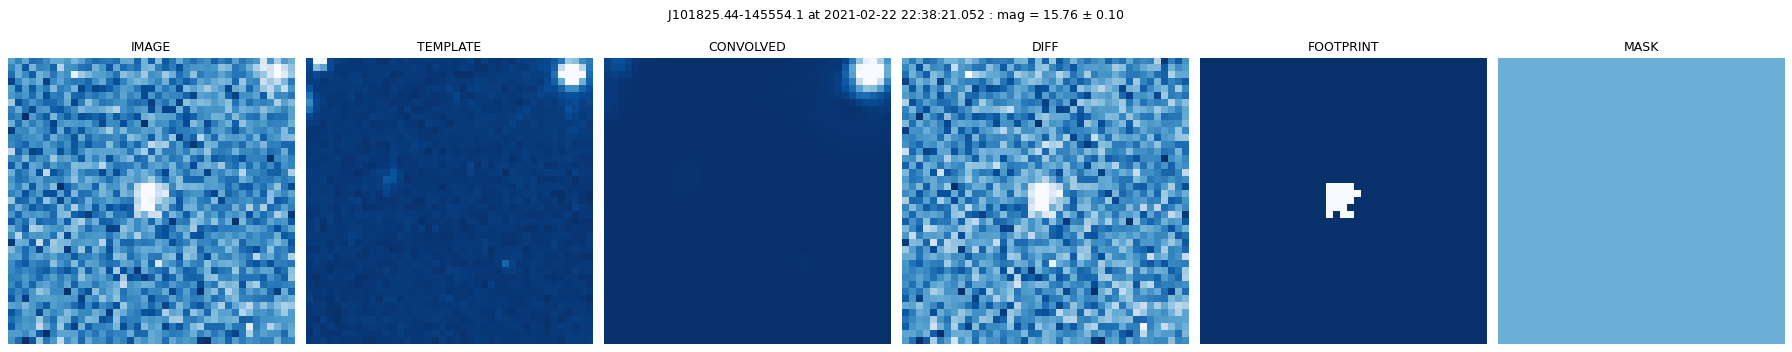

In [28]:
for i,cand in enumerate(candidates):
        print('Candidate %d with mag = %.2f +/- %.2f at x/y = %.1f %.1d and RA/Dec = %.4f %.4f' 
              % (i, cand['mag_calib'], cand['mag_calib_err'], cand['x'], cand['y'], cand['ra'], cand['dec']))
        
        print('SPREAD_MODEL = %.3f +/- %.3f, CLASS_STAR = %.2f' 
              % (cand['spread_model'], cand['spreaderr_model'], cand['CLASS_STAR']))
        
        cutout = cutouts.get_cutout(
            image, 
            cand, 
            20, 
            mask=mask | tmask | dmask, 
            diff=diff, 
            template=tmpl, 
            convolved=conv, 
            err=ediff, 
            footprint=(segm == cand['NUMBER']), 
            header=header, 
            filename=filename, 
            time=time
        )
        
        plots.plot_cutout(
            cutout, 
            ['image', 'template', 'convolved', 'diff', 'footprint', 'mask'], 
            qq=[0.5, 99.5], 
            stretch='linear'
        )
        
        plt.show()

We successfully recovered the actual transient, and this time no blended stars are in our way! 

# Appendix

Below we demonstrate some additional things that *STDPipe* may do.

## Templates - HiPS (optional)

Alternative way for getting the templates that is implemented in *STDPipe* is downloading the images from CDS [hips2fits](http://alasky.u-strasbg.fr/hips-image-services/hips2fits) service, which is serving the cutouts from any survey available in HiPS ([Hierarchical Progressive Surveys](http://aladin.u-strasbg.fr/hips/)) format. Takeaway message for it is:
 - any survey [listed here](http://aladin.u-strasbg.fr/hips/list) may be used for getting the template
     - most important for us are Pan-STARRS ($\delta>-30$ deg) and SkyMapper ($\delta<0$ deg, but quite poor depth), as well as DESI Legacy Survey (regions outside Galactic plane on both southern and northern sky, even deeper than Pan-STARRS)
     - for Pan-STARRS we automatically convert original `asinh` flux scaling to linear counts
 - the image may be requested in any projection specified by WCS header, so no re-projection is necessary
 - ⚠️**HiPS projection algorithm is not *exactly* flux conserving, and `asinh` scaling currently used for storing Pan-STARRS images at CDS makes it even worse for undersampled cases, i.e. for pixel scale worse than 1 arcsec/pixel**
     - as a workaround, we may request the image with 2x resolution and then downscale it (has to be done manually for now)
 - HiPS represents surveys masked pixels as `NaNs`, but its projection algorithm may smooth them out, so masking should be handled with care

In [29]:
# Get r band image from PanSTARRS with science image original resolution and orientation
tmpl = templates.get_hips_image(
    'PanSTARRS/DR1/r', 
    wcs=wcs, 
    width=image.shape[1], 
    height=image.shape[0], 
    get_header=False
)

# Get r band image from PanSTARRS with 2x resolution (as we have large pixel scale) and downsample it 
# tmpl = templates.get_hips_image(
#     'PanSTARRS/DR1/r', 
#     wcs=wcs[::0.5,::0.5], 
#     width=image.shape[1]*2, 
#     height=image.shape[0]*2, 
#     get_header=False, 
#     verbose=True
# )
# tmpl = utils.rebin_image(tmpl, 2)

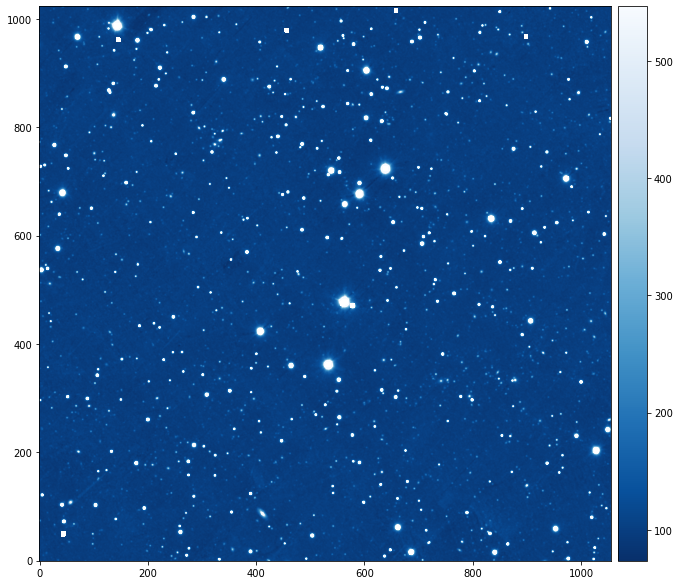

In [30]:
plots.imshow(tmpl)

## HiPS template masking

Templates, especially acquired from different instruments or surveys, are not perfect, and some pixels on them should be masked before image subtraction. In HiPS case, where no additional masks are available for download, we should do the following:
 - mask `NaNs` in the template, as they represent (some fraction of) originally masked pixels from the survey
 - mask the stars that are brighter than survey saturation limit, even if HiPS does not contain `NaNs` for them
 
The latter is especially important for red bands of Pan-STARRS, where e.g. the stars above $r\approx15$ are saturated on individual exposures, but not flagged on publicly available coadds!

(-2.0, 2.0)

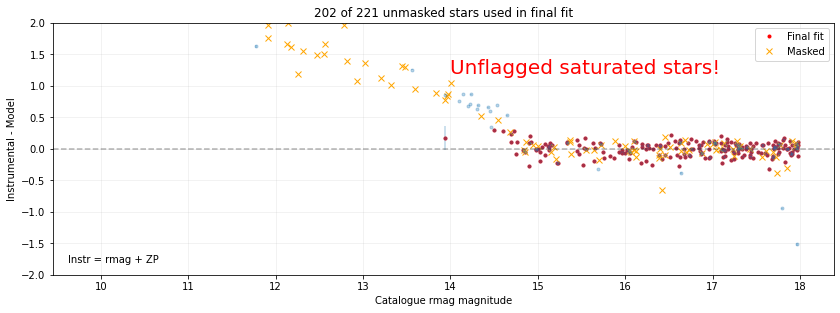

In [31]:
# To demonstrate it, let's perform the photometry on template and match it with catalogue
tobj = photometry.get_objects_sextractor(
    tmpl, 
    mask=~np.isfinite(tmpl), 
    wcs=wcs, 
    aper=3, 
    gain=0
)

m_tmpl = pipeline.calibrate_photometry(
    tobj, 
    cat, 
    sr=1/3600, 
    cat_col_mag='rmag', 
    cat_col_mag_err='e_rmag', 
    max_intrinsic_rms=0.1, 
    verbose=False
)

plt.subplot(211)
plots.plot_photometric_match(
    m_tmpl, 
    mode='mag'
)
plt.text(14, 1.2, 'Unflagged saturated stars!', color='red', fontsize=20)
# plt.text(15.2, 0.4, 'Scatter due to undersampled HiPS template', color='blue', fontsize=12)
plt.ylim(-2, 2)

The routine `templates.mask_template` masks the template pixels that are either
 - set to `NaN`
 - close to the positions of catalogue stars brighter some threshold
 
It also optionally dilates the resulting mask, so that the pixels close to already masked are masked too (wings of saturated stars, etc)

192 template pixels masked after NaN checking
246 template pixels masked after checking saturated (rmag < 15.0) stars
Dilating the mask with 3 x 3 kernel
2837 template pixels masked after dilation


Text(0.5, 1.0, 'Template mask')

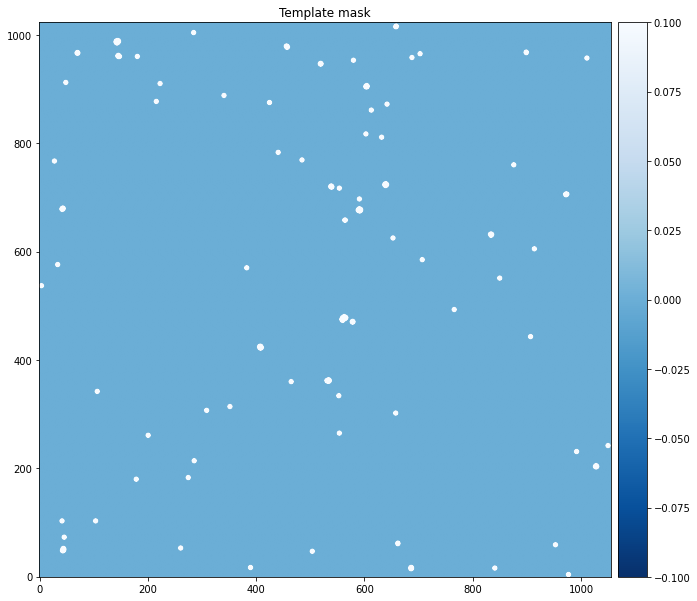

In [32]:
tmask = templates.mask_template(
    tmpl, 
    cat, 
    cat_col_mag='rmag', 
    cat_saturation_mag=15, 
    wcs=wcs, 
    dilate=3, 
    verbose=True
)

plots.imshow(tmask)
plt.title('Template mask')

## Testing flux conservation in HiPS images

We may directly see the effect of *inexact* flux conservation in Pan-STARRS HiPS images (caused primarily by `asinh` scaling used to store them at CDS) depending on requested pixel scale by comparing the photometry on HiPS images with the "official" photometric catalogue derived (supposedly) from the same coadds. Let's do it!

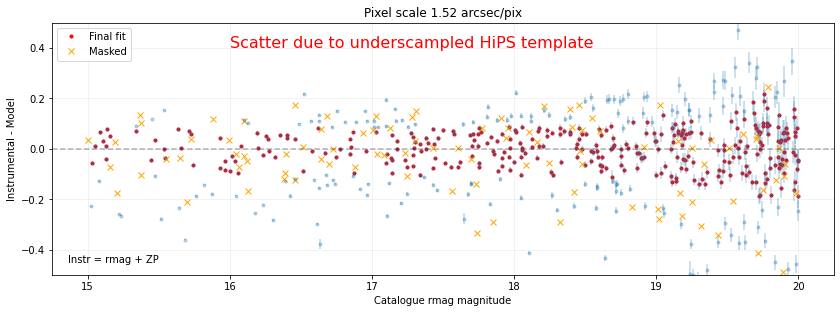

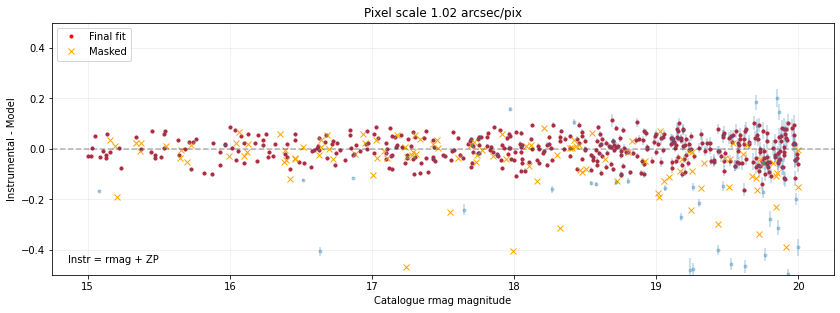

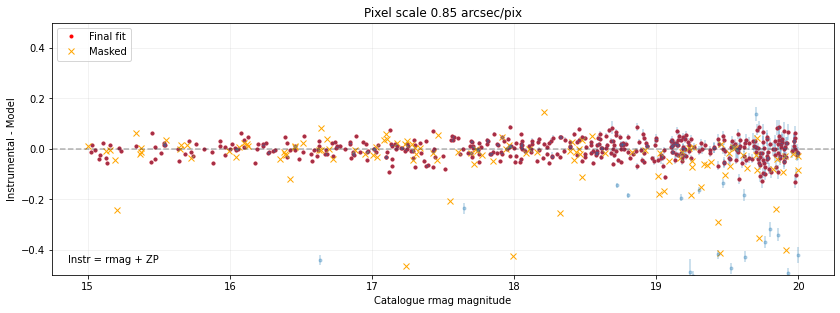

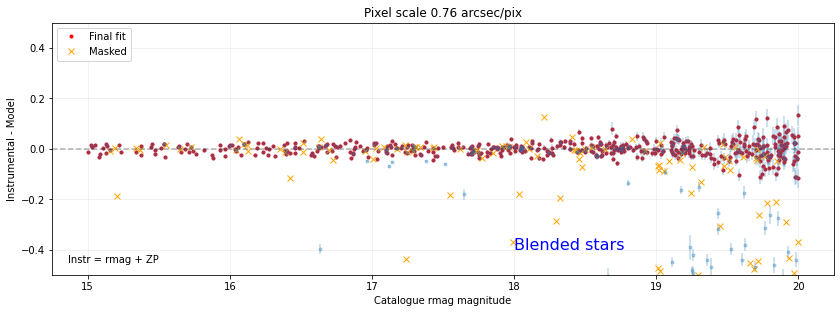

In [33]:
cat1 = catalogs.get_cat_vizier(
    center_ra, 
    center_dec, 
    center_sr, 
    'ps1', 
    filters={'rmag':'15..20'}
)

for scale in [1, 1.5, 1.8, 2]:
    wcs1 = wcs[::1/scale, ::1/scale] # Rescaled WCS solution
    tmpl1 = templates.get_hips_image(
        'PanSTARRS/DR1/r', 
        wcs=wcs1, 
        width=image.shape[1]*scale, 
        height=image.shape[0]*scale, 
        get_header=False
    )
    
    tobj = photometry.get_objects_sextractor(
        tmpl1, 
        mask=~np.isfinite(tmpl1), 
        wcs=wcs1, 
        aper=2*scale, 
        gain=0
    )
    
    m = pipeline.calibrate_photometry(
        tobj, 
        cat1, 
        sr=1/3600, 
        cat_col_mag='rmag', 
        cat_col_mag_err='e_rmag', 
        max_intrinsic_rms=0.02, 
        bg_order=2, 
        verbose=False
    )

    plt.subplot(211)
    plots.plot_photometric_match(m, mode='mag')
    plt.ylim(-0.5, 0.5)
    plt.title('Pixel scale %.2f arcsec/pix' 
              % (3600*astrometry.get_pixscale(wcs=wcs1)))
    if scale == 1:
        plt.text(16, 0.4, 'Scatter due to underscampled HiPS template', color='red', fontsize=16)
    if scale == 2:
        plt.text(18, -0.4, 'Blended stars', color='blue', fontsize=16)
        
    plt.show()

So it seems using the pixel scale a bit below 1 arcsecond per pixel gives quite acceptable photometric accuracy of returned HiPS image.

## PSF photometry

We do not have any dedicated PSF photometry code implemented in *STDPipe* right now, but we may use *SExtractor* + *PSFEx* to do it. It is a bit limited in scope, as it does not support PSF-based detection and deblending, nor group photometry. But it often helps anyway, so let's show how to do it.

`psf.run_psfex` is a simple wrapper around *PSFEx* that automatically builds PSF model from the image, and returns it as an object (usable e.g. for placing realistically looking artificial stars into the image). However, we do not (yet) have the code to write this structure back to file, so in order to use it inside *SExtractor* we need to directly ask the routine to store it to some temporary file. Of course, in real pipeline the filename should be randomly generated, and the file should be disposed after use!

Then, `photometry.get_objects_sextractor` accepts an argument `psf` which should be the filename of PSF model. Then it will automatically use it, and add several extra columns to the output (**mag_psf, magerr_psf, chi2_psf, spread_model**, etc). Finally, we may use these measurements for photometric calibration.

In [34]:
# We do not have enough stars to study PSF spatial variance, so we use order=0 here
psf_model = psf.run_psfex(
    image, mask=mask, 
    order=0, 
    gain=gain, 
    psffile='/tmp/psf.psf', 
    verbose=True
)

obj_psf = photometry.get_objects_sextractor(
    image, 
    mask=mask, 
    aper=3.0, 
    edge=10, 
    gain=gain, 
    wcs=wcs, 
    psf='/tmp/psf.psf', 
    verbose=False
)

m_psf = pipeline.calibrate_photometry(
    obj_psf, 
    cat, 
    sr=1/3600, 
    obj_col_mag='mag_psf', 
    obj_col_mag_err='magerr_psf', 
    cat_col_mag='rmag', 
    cat_col_mag1='gmag', 
    cat_col_mag2='rmag', 
    order=2, 
    max_intrinsic_rms=0.02, 
    verbose=False
)

Aperture size not specified, will estimate it from image FWHM
Will run SExtractor like that:
/Users/karpov/opt/miniconda3/envs/stdpipe/bin/sex /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/psfexejqbmd4y/image.fits -c /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/psfexejqbmd4y/empty.conf -VERBOSE_TYPE QUIET -DETECT_MINAREA 5 -GAIN 1.167 -DETECT_THRESH 2.0 -WEIGHT_TYPE BACKGROUND -MASK_TYPE NONE -SATUR_LEVEL 31969.890486097178 -FLAG_IMAGE /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/psfexejqbmd4y/flags.fits -PHOT_APERTURES 6.0 -PARAMETERS_NAME /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/psfexejqbmd4y/cfg.param -CATALOG_NAME /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/psfexejqbmd4y/out.cat -CATALOG_TYPE FITS_LDAC -FILTER N
SExtractor run succeeded
FWHM = 4.5 pixels, will use aperture radius 8.9 pixels
Extracting PSF using vignette size 54 x 54 pixels
Will run SExtractor like that:
/Users/karpov/opt/miniconda3/envs/stdpipe/bin/sex /var/folders/82/92l2np5529qbpckrl8ttlj2


> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



PSFEx run succeeded
Loading PSF model from /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/psfexejqbmd4y/out.psf
PSF model 25 x 25 pixels, FWHM 3.6 pixels, sampling 0.76, degree 0
PSF model stored to /tmp/psf.psf


(0.0, 1.5)

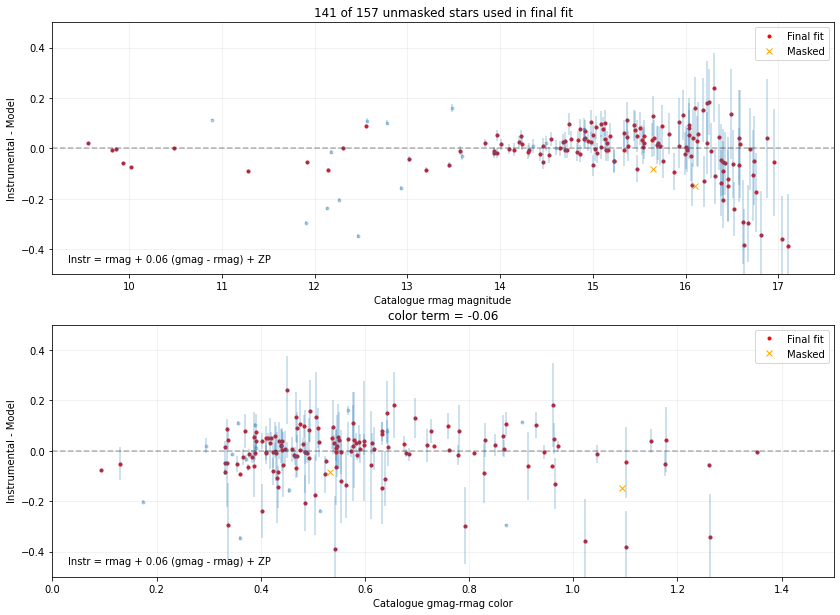

In [35]:
plt.subplot(211)
plots.plot_photometric_match(m_psf)
plt.ylim(-0.5, 0.5)

plt.subplot(212)
plots.plot_photometric_match(m_psf, mode='color')
plt.ylim(-0.5, 0.5)
plt.xlim(0.0, 1.5)

Well, it does not help much in our specific case.

## Convenience routines: splitting the image into sub-images

Often you have quite large image, with significant variation of PSF, background etc over it. Such frames are not very well suited for image subtraction, as convolution kernel will become unstable and / or unable to properly match the resolutions of image and template. 

So, for such images, it is better to split them into smaller pieces and do image subtraction on the latters. When splitting, however, you have to also split the mask, update WCS solution and FITS header, maybe select a subset of catalogue stars, etc etc. And we have a dedicated routine for doing just that!

In [36]:
# Crop the image (mask, header, WCS, object list and catalogue too) into several pieces, adding 10 pixels wide overlap
for x0, y0, image1, mask1, header1, wcs1, obj1, cat1 in pipeline.split_image(
    image, 
    nx=2, 
    mask=mask, 
    header=header, 
    wcs=wcs, 
    obj=obj, 
    cat=cat, 
    overlap=10, 
    get_origin=True, 
    verbose=True):
    # Do something useful on the sub-images here!
    pass

Will split the image (1056x1024) into 2x2 pieces with 528x512 pixels size and 10 pix overlap
Block 0: 0 0 - 538 522
Block 1: 0 502 - 538 1024
Block 2: 518 0 - 1056 522
Block 3: 518 502 - 1056 1024


## Placing artificial stars into the image

We have a simple routine, `pipeline.place_random_stars`, that generates the list of randomly placed artificial stars with log-uniform flux distribution and places them inside the image. The stars are based on user-provided PSF model, and thus should be identical in shape to original image contents. It may be used for experiments with detection efficiency. It is covered in more details [in a separate notebook](simulated_stars.ipynb).

